In [1]:
# plot KE min results

import numpy as np
import matplotlib.pyplot as plt

import os
import sys
import pickle
import copy
from scipy.io import savemat
from scipy.linalg import schur
from sklearn.cluster import DBSCAN as dbscan
#from dynamics.process.rnn.parse import KEconvert2matlab
from scipy.stats import ranksums, wilcoxon
import glob
import warnings
from sklearn.metrics import pairwise_distances
from os.path import exists
from scipy import interpolate
from copy import deepcopy

import json

from scipy.stats import ks_2samp
from dynamics.process.rnn import wt_kindergarten, wt_nets, wt_costs, wt_reinforce_cont_new, wt_pred, parse, parse_state
%load_ext autoreload
%autoreload 2

warnings.filterwarnings("ignore", message="Trying to unpickle estimator PCA*")


In [2]:
def KEconvert2matlab(fname, dosave=True, eps=3, doadaptive=False, savedir=None):
    """
    extracts the fixed and slow points from KE minization file, clusters with DBSCAN,
    then converts to a matlab file
    :param fname: file name of kinetic energy minima located by minimization
    :param dosave: if true, saves .mat file. otherwise just returns dict
    :param eps: the DBscan parameter
    :param doadaptive: should the epsilon parameter be chosen adaptive for each network, based on PC1 range?
    :param savedir: if None, save in original data dir. this helps for trying different hyperparams
    :return: (dict) of coordinates, schur modes, eigenvalues, etc.
    """

    if not exists(fname):
        #print('data file does not exist')
        return None

    if fname.split('.')[-1] == 'dat':
        #print('loading legacy .dat data')
        with open(fname, 'rb') as f:
            dat = pickle.load(f)

    # format everything into a matlab-friendly thing
    ns = len(dat['output'])
    #crds = np.array([[dat['output'][k][0][0], dat['output'][k][0][1]] for k in range(ns)])  # assume 2d
    crds = np.array([dat['output'][k][0] for k in range(ns)])
    KE = np.array([dat['output'][k][1] for k in range(ns)])
    jac_pc = np.array([dat['output'][k][2][0] for k in range(ns)])
    evals_full = np.array([dat['output'][k][2][1] for k in range(ns)])
    D = crds.shape[1]
    
    

    # filter the data into slow and fast points, then cluster to get the effecgtive points
    # create cutoffs for fixed points and slow points. filter data
    mask_fixed = KE < 0.0001

    # define slow points that only change magnitude < 5% across duration of trial
    lam = 2.5
    dt = 0.05
    eps_norm = 0.05
    eps_fp = 1e-3
    sdiffnorm = 2 * np.sqrt(KE) * lam / (np.linalg.norm(crds, axis=1))
    mask_slow = sdiffnorm < eps_norm

    mask = (mask_fixed) | (mask_slow)
    # potentially get ride of this
    mask = np.ones(mask.shape).astype(bool)

    crds_masked = crds[mask, :]
    KE_masked = KE[mask]
    jac_pc_masked = jac_pc[mask, :, :]
    evals_full_masked = evals_full[mask, :]
    sdiffnorm_masked = sdiffnorm[mask]
    isfixed_masked = KE_masked < 0.0001
    ns_masked = sum(mask)
    
    
    #decide on hyperparameter
    if doadaptive:
        xvals = [k[0][0] for k in dat['crds']]
        xrange = max(xvals)-min(xvals)
        eps = np.abs(xrange*eps)
        if eps==0:
            print('issue with range')
            return None
        
    
    #find number of dynamical systems features
    clustering = dbscan(eps=eps, min_samples=10).fit(crds_masked)
    labs = np.unique(clustering.labels_)
    labels = clustering.labels_
    
    #analyze the spread of each feature. relevant only for line attractors, but that analysis is later
    featurelen = []
    for k in labs:
        pts = crds_masked[labels==k]
        featurelen.append(np.max(pairwise_distances(pts)))
    
    fetdict = dict(zip(labs,featurelen))
    
    # TODO: determine if each labeled feature is in range. give it a bit of a buffer of 30%
    min_pcvals = []
    max_pcvals = []
    for m in range(D):
        min_pcvals.append(1.3*np.min(np.array([k[0][m] for k in dat['crds']])))
        max_pcvals.append(1.3*np.max(np.array([k[0][m] for k in dat['crds']])))
        
    inrange = []  # is each masked fixed/slow point within bounds of PC_min and PC_max?    
    for k in crds_masked:
        cond_all = True
        for m in range(D):
            cond_m = k[m] > min_pcvals[m] and k[m] < max_pcvals[m]  # if out of range for any PC
            cond_all = cond_all and cond_m
        inrange.append(cond_all)
            
    
    
    

    savedict = {'ns': ns_masked, 'crds': crds_masked, 'KE': KE_masked, 'jac_pc': jac_pc_masked,
                'evals_full_masked': evals_full, 'statediff': sdiffnorm_masked, 'labels': labels,
                'isfixed': isfixed_masked, 'fetdict':fetdict, 'D':D, 'inrange':inrange}
    if dosave:
        if savedir is None:
            savemat(fname.split('.')[0] + '.mat', savedict)
        else:
            savename = savedir + fname.split('/')[-1].split('.')[0]+'.mat'
            savemat(savename, savedict)
    return savedict

In [3]:


ttype = 'full_cl_20231003'
epoch = 'wait'
reg_idx = 0

def getdirname(ttype,epoch, num=None, reg_idx = 0):

    if ttype == 'full_cl':
        #dirname = '/Users/dhocker/projects/dynamics/results/rnn/ac/20230206_fullclstudy/full_cl_redo/dynamics/'  
        dirname = '/scratch/dh148/dynamics/results/rnn/ac/20230206_clstudy/full_cl_redo/dynamics/KEmin_constrained/' 
        if epoch == 'wait':
            txt = 'kemin_rnn_curric_*block_10reg_'+str(reg_idx)+'_D2_wait.dat'
        elif epoch == 'iti':
            txt = 'kemin_rnn_curric_*block_10reg_'+str(reg_idx)+'_D2_iti.dat'
        elif epoch == 'start':
            txt = 'kemin_rnn_curric_*block_10reg_'+str(reg_idx)+'_D2_start.dat'
        dirnames = glob.glob(dirname+txt)
        tphase = 5*np.ones((len(dirnames)))
    elif ttype == 'full_cl_20231003':
        #dirname = '/Users/dhocker/projects/dynamics/results/rnn/ac/20230206_fullclstudy/full_cl_redo/dynamics/'  
        #dirname = '/scratch/dh148/dynamics/results/rnn/ac/20230206_clstudy/full_cl_redo/dynamics/KEmin_constrained/' 
        dirname = '/scratch/dh148/dynamics/results/rnn/ac/20231003/full_cl/dynamics/KEmin_constrained/' 
        if epoch == 'wait':
            txt = 'kemin_rnn_curric_*block_10reg_'+str(reg_idx)+'_mixed_wait.dat'
        elif epoch == 'iti':
            txt = 'kemin_rnn_curric_*block_10reg_'+str(reg_idx)+'_mixed_iti.dat'
        elif epoch == 'start':
            txt = 'kemin_rnn_curric_*block_10reg_'+str(reg_idx)+'_mixed_start.dat'
        dirnames = glob.glob(dirname+txt)
        tphase = 5*np.ones((len(dirnames)))
    elif ttype == 'nok_cl':
        #dirname = '/Users/dhocker/projects/dynamics/results/rnn/ac/20230206_fullclstudy/nok_cl/dynamics/'
        dirname = '/scratch/dh148/dynamics/results/rnn/ac/20231003/nok_cl/dynamics/KEmin_constrained/' 
        if epoch == 'wait':
            txt = 'kemin_rnn_curric_*block_60reg_'+str(reg_idx)+'_mixed_wait.dat'
        elif epoch == 'iti':
            txt = 'kemin_rnn_curric_*block_60reg_'+str(reg_idx)+'_mixed_iti.dat'
        elif epoch == 'start':
            txt = 'kemin_rnn_curric_*block_60reg_'+str(reg_idx)+'_mixed_start.dat'
        dirnames = glob.glob(dirname+txt)
        tphase = 5*np.ones((len(dirnames)))

    
    #if doing time dependence, do this in order
    if ttype == 'full_cl_time':
        #dirname = '/scratch/dh148/dynamics/results/rnn/ac/20230206_clstudy/full_cl_redo/dynamics/KEmin_constrained/'       
        dirname = '/scratch/dh148/dynamics/results/rnn/ac/20231003/full_cl/dynamics/KEmin_constrained/'     
        dirnames = []
        tphase = []
    
        
        txt = 'kemin_rnn_kindergarten_'+str(num)+'_simplereg_'+str(reg_idx)+'_kind_'+epoch+'.dat'
        dirnames.append(dirname+txt)
        tphase.append(0)
        
        
        for k in range(1,11):
            txt = 'kemin_rnn_kindergarten_'+str(num)+'_int_0_'+str(k)+'reg_'+str(reg_idx)+'_kind_'+epoch+'.dat'
            dirnames.append(dirname+txt)
        tphase.extend(1*np.ones((10,)))
        for k in range(1,101,1):
            txt = 'kemin_rnn_pred_'+str(num)+'_'+str(k)+'reg_'+str(reg_idx)+'_kind_'+epoch+'.dat'
            dirnames.append(dirname+txt)
        tphase.extend(2*np.ones((100,)))
        
        for k in range(1,11):
            txt = 'kemin_rnn_curric_'+str(num)+'_nocatch_'+str(k)+'reg_'+str(reg_idx)+'_mixed_'+epoch+'.dat'
            dirnames.append(dirname+txt)
        tphase.extend(3*np.ones((10,)))
        for k in range(1,11):
            txt = 'kemin_rnn_curric_'+str(num)+'_catch_'+str(k)+'reg_'+str(reg_idx)+'_mixed_'+epoch+'.dat'
            dirnames.append(dirname+txt)
        tphase.extend(4*np.ones((10,)))
        for k in range(1,11):
            txt = 'kemin_rnn_curric_'+str(num)+'_block_'+str(k)+'reg_'+str(reg_idx)+'_mixed_'+epoch+'.dat'
            dirnames.append(dirname+txt)
        tphase.extend(5*np.ones((10,)))

    
    
    return dirnames, tphase
dirnames, tphase = getdirname(ttype,epoch)
dirnames[0]


'/scratch/dh148/dynamics/results/rnn/ac/20231003/full_cl/dynamics/KEmin_constrained/kemin_rnn_curric_12_block_10reg_0_mixed_wait.dat'

In [4]:
def classify(eigs):
    """will classify eigenvalue as 
      - attractor (stable) both < 1
      - source (unstable) both > 1
      - saddle (semistable eig_1 < 1, eig2 > 1)
      - line attractor (one eig is unity, within a tolerance)
      
      (handle these later. need to check textbook)
      - stablespiral (complex eigenvalues), norm < 1
      - unstable spiral (complex)
      - orbit (purely imaginary)"""
    
    e1 = eigs[0]
    e2 = eigs[1]
    
    tol1_low = 0.999
    tol1_high = 1.001
    
    
    if e1<tol1_low and e2 < tol1_low:
        return 'attractor'
    elif e1 > tol1_high and e2 > tol1_high:
        return 'source'
    elif e1 < tol1_low and e2 > tol1_high:
        return 'saddle'
    elif e2 < tol1_low and e1 > tol1_high:
        return 'saddle'
    elif e1 < tol1_high and e1 > tol1_low:
        return 'line'
    elif e2 < tol1_high and e2 > tol1_low:
        return 'line'
    else:
        print('i missed something:' + str(eigs))
        return None
    

In [5]:
def classify_gen(eigs,D=2):
    """will classify eigenvalues in arbitraty dim as 
      - attractor (stable) both < 1
      - source (unstable) both > 1
      - saddle (semistable eig_1 < 1, eig2 > 1)
      - line attractor (one eig is unity, within a tolerance)
      
      (handle these later. need to check textbook)
      - stablespiral (complex eigenvalues), norm < 1
      - unstable spiral (complex)
      - orbit (purely imaginary)"""
    
    tol1_low = 0.999
    tol1_high = 1.001
    
    ltmask = eigs < tol1_low # attractors
    gtmask = eigs > tol1_high # unstable
    linemask = (eigs > tol1_low) & (eigs < tol1_high) #lines
    
    if np.sum(ltmask) == D:
        return 'attractor'
    elif np.sum(gtmask) == D:
        return 'source'
    elif np.sum(linemask) > 0:
        return 'line'
    elif np.sum(ltmask) > 0 and np.sum(gtmask) > 0:
        return 'saddle'
    else:
        print('i missed something'+ str(eigs))
        return None
    
    

In [6]:
def getnpts(dirnames,tphase, subtype='fixed', eps=3, doadaptive=False, savedir=None, restrictrange=False):
    """helper script to get number and type of fixed points
        if savedir is None: defautl to saving things in datadir. useful for different eps runs
        restrictrange is for excluding feature outside range of PC activity """
    nfixed_all = []
    nslow_all = []
    ntot = []
    
    nattractor_all = []
    nsaddle_all = []
    nline_all = []
    nsource_all = []
    ctr = 0
    cutctr = 0
    
    dirnamecpy = copy.deepcopy(dirnames)
    tphasecpy = copy.deepcopy(tphase)
    
    fetlen_all = []
    fetlentype_all = []
    inrange_all = []
    Dall = []
    
    for m in dirnames:
        #try:
        if savedir is None:
            dosave = False
        else:
            dosave = True

        dat = KEconvert2matlab(m,dosave = dosave, eps=eps, doadaptive=doadaptive, savedir=savedir)
        #except:
        #    print('issue with file:'+m)
        #    dat = None
        
        if dat is None:
            #print('didnt exist: '+m)        
            nfixed = np.nan
            nslow = np.nan
            nattractor = np.nan
            nsaddle = np.nan
            nline = np.nan
            nsource = np.nan
            npts = []
            D = np.nan
            #maximum length of feature, and its type
            fetlen = []
            fetlentype = []

        else:
            D = dat['D']
            
            if restrictrange:
                mask = dat['inrange']
            else:
                mask = np.ones(len(dat['labels'])).astype(bool)            
                
            npts = np.unique(dat['labels'][np.array(dat['labels']>-1) & np.array(mask)])

            nfixed = 0
            nslow = 0
            nattractor = 0
            nsaddle = 0
            nline = 0
            nsource = 0
            
            #maximum length of feature, and its type
            fetlen = []
            fetlentype = []
            
            #also track if feature is is in the range of network activity
            inrange = []


            for k in npts:
                pt_k_idx = np.argwhere(dat['labels']==k)[0,0]
                
                fetlen.append(dat['fetdict'][k])
                inrange.append(dat['inrange'][k])
                
                
                if dat['isfixed'][pt_k_idx]:
                    nfixed+=1
                else:
                    nslow+=1

                test = schur(dat['jac_pc'][pt_k_idx], output='real')
                evals = np.diag(test[0])
                #c = classify(evals)
                c = classify_gen(evals,D)
                #types.append(c)
                
                #add points only if following condition is met
                cond1 = dat['isfixed'][pt_k_idx] and subtype=='fixed' #update only if fixed
                cond2 = not dat['isfixed'][pt_k_idx] and subtype=='slow' #update only if slow
                cond3 = subtype == 'all' #update all of them

                #only update if fixed
                if cond1 or cond2 or cond3:
                    if c == 'attractor':
                        nattractor +=1
                        fetlentype.append('attractor')
                    elif c == 'saddle':
                        nsaddle +=1
                        fetlentype.append('saddle')
                    elif c == 'line':
                        nline +=1
                        fetlentype.append('line')
                    elif c == 'source':
                        nsource +=1     
                        fetlentype.append('source')
                    else:
                        print('none chosen')
                        

        nfixed_all.append(nfixed)
        nslow_all.append(nslow)
        ntot.append(len(npts))
        nattractor_all.append(nattractor)
        nsaddle_all.append(nsaddle)
        nline_all.append(nline)
        nsource_all.append(nsource)
        fetlen_all.append(fetlen)
        fetlentype_all.append(fetlentype)
        Dall.append(D)
        inrange_all.append(inrange)
        

        
    typelist = [nattractor_all, nsaddle_all, nline_all, nsource_all]

    
    return nfixed_all, nslow_all, ntot, typelist, dirnamecpy, tphasecpy, fetlen_all, fetlentype_all, Dall, inrange_all

    

In [10]:
#Fig. E. the end-of-training cumulative plot

st = 'all'
#vers = 'full_cl'  #the old kind CL reult
vers = 'full_cl_20231003' #the new cl results

#reg_idx = 0 # for OFC results
reg_idx = 1  # for STR results

#eps = 3
#doadaptive = False

#savedir = '/scratch/dh148/dynamics/results/rnn/ac/20231003/full_cl/dynamics/eps001/'
#savedir = '/scratch/dh148/dynamics/results/rnn/ac/20231003/full_cl/dynamics/eps01/'
#savedir = '/scratch/dh148/dynamics/results/rnn/ac/20231003/full_cl/dynamics/eps05/'
#savedir = '/scratch/dh148/dynamics/results/rnn/ac/20231003/full_cl/dynamics/eps1/'

savedir = None


eps = 0.01  # ratio of PC1 range
doadaptive = True
restrictrange = False

dirnames, tphase = getdirname(vers,'wait', reg_idx=reg_idx)
npts_kind_wait = getnpts(dirnames,tphase,st, eps=eps, doadaptive=doadaptive,savedir=savedir, restrictrange=restrictrange)

dirnames, tphase = getdirname(vers,'iti', reg_idx=reg_idx)
npts_kind_iti = getnpts(dirnames,tphase,st, eps=eps, doadaptive=doadaptive,savedir=savedir,restrictrange=restrictrange)

dirnames, tphase = getdirname(vers,'start', reg_idx=reg_idx)
npts_kind_start = getnpts(dirnames,tphase,st, eps=eps, doadaptive=doadaptive,savedir=savedir,restrictrange=restrictrange)


dirnames, tphase = getdirname('nok_cl','wait', reg_idx=reg_idx)
npts_classic_wait = getnpts(dirnames,tphase,st, eps=eps, doadaptive=doadaptive,savedir=savedir,restrictrange=restrictrange)

dirnames, tphase = getdirname('nok_cl','iti', reg_idx=reg_idx)
npts_classic_iti = getnpts(dirnames,tphase,st, eps=eps, doadaptive=doadaptive,savedir=savedir,restrictrange=restrictrange)

dirnames, tphase = getdirname('nok_cl','start', reg_idx=reg_idx)
npts_classic_start = getnpts(dirnames,tphase,st, eps=eps, doadaptive=doadaptive,savedir=savedir,restrictrange=restrictrange)




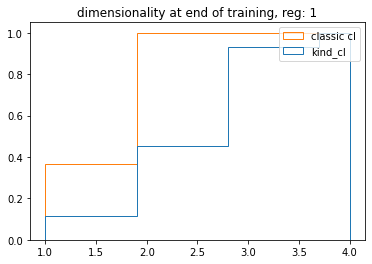

KstestResult(statistic=0.08592017738359202, pvalue=0.9904104289294761)


/ext3/miniconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:997: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a = asanyarray(a).copy(order="K")


In [11]:
#try plotting dimensionality?
savedir = '/scratch/dh148/dynamics/results/rnn/ac/20231003/figs/'
#plt.hist([npts_kind_wait[-2],npts_classic_wait[-2]],label=['kind_cl','classic cl'], width=0.8, stacked=True)
plt.hist([npts_kind_wait[-2],npts_classic_wait[-2]],label=['kind_cl','classic cl'],
         cumulative=True,histtype='step', density=True)

#plt.hist(npts_classic_wait[-1],label='classic cl',width=0.8)
plt.legend()
plt.title('dimensionality at end of training, reg: '+str(reg_idx))
plt.savefig(savedir+'dimen_reg_'+str(reg_idx)+'.pdf')
plt.show()

ksres = ks_2samp(npts_kind_wait[-1], npts_classic_wait[-1])
print(ksres)


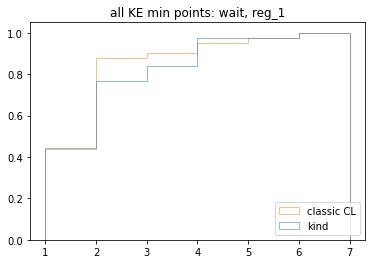

KstestResult(statistic=0.10532150776053215, pvalue=0.943530791307105)


In [12]:


savedir = '/scratch/dh148/dynamics/results/rnn/ac/20231003/figs/'

plt.hist([npts_kind_wait[2],npts_classic_wait[2]],bins = [1,2,3,4,5,6,7],
         cumulative=True,histtype="step", alpha = 0.5,density=True, label=['kind','classic CL'])

plt.legend(loc='lower right')

#plt.hist([npts_kind_wait[2],npts_classic_wait[2]],bins = [1,2,3,4,5,6,7],
#         cumulative=False,histtype="bar",stacked=True, alpha = 0.5,density=True, label=['kind','classic CL'])
#plt.legend(loc='upper right')

plt.title('all KE min points: wait, reg_'+str(reg_idx) )


savename = savedir + 'numfeatures_reg'+str(reg_idx)
#savename = savedir + 'numfeatures_reg_nocumulative'+str(reg_idx)
plt.savefig(savename+'.pdf')
plt.show()

ksres = ks_2samp(npts_kind_wait[2], npts_classic_wait[2])
print(ksres)



In [10]:
np.mean(npts_kind_wait[2])

1.9545454545454546

In [20]:
savedir

'/scratch/dh148/dynamics/results/rnn/ac/20230206_clstudy/full_cl_redo/dynamics/KEmin_constrained/'

/ext3/miniconda3/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


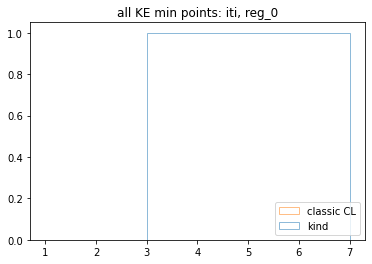

ValueError: Data passed to ks_2samp must not be empty

In [26]:
# supp figs.  TODO: not simulated for 20231003

plt.hist([npts_kind_iti[2],npts_classic_iti[2]],bins = [1,2,3,4,5,6,7],
         cumulative=True,histtype="step", alpha = 0.5,density=True, label=['kind','classic CL'])
plt.title('all KE min points: iti, reg_'+str(reg_idx) )
plt.legend(loc='lower right')

savename = savedir + 'numfeatures_reg'+str(reg_idx)+'_iti'
#plt.savefig(savename+'.pdf')
plt.show()

ksres = ks_2samp(npts_kind_iti[2], npts_classic_iti[2])
print(ksres)


plt.hist([npts_kind_start[2],npts_classic_start[2]],bins = [1,2,3,4,5,6,7],
         cumulative=True,histtype="step", alpha = 0.5,density=True, label=['kind','classic CL'])
plt.title('all KE min points: offer pres, reg_'+str(reg_idx) )
plt.legend(loc='lower right')

savename = savedir + 'numfeatures_reg'+str(reg_idx)+'_offer'
#plt.savefig(savename+'.pdf')
plt.show()

ksres = ks_2samp(npts_kind_start[2], npts_classic_start[2])
print(ksres)



In [31]:
# try the pop average
npts_all = []
npts_all_str = []

#userange = range(1,21)
#userange = [2,3,4,5,6,7,8,9,10,11,13,14,15,16,18,19]  #until all networks are done
userange = range(1,51)

eps = 0.01
doadaptive = True


for j in userange:
    print(j)
    st = 'all'
    ttype = 'full_cl_time'
    epoch = 'wait'
    num = j
    reg_idx = 0
    dirnames, tphase = getdirname(ttype,epoch,num,reg_idx)
    npts_kind_wait = getnpts(dirnames,tphase,st, eps=eps, doadaptive=doadaptive)
    npts_j = np.array(npts_kind_wait[0])+np.array(npts_kind_wait[1])
    npts_all.append(npts_j)
    
for j in userange:
    print(j)
    st = 'all'
    ttype = 'full_cl_time'
    epoch = 'wait'
    num = j
    reg_idx = 1
    dirnames, tphase_str = getdirname(ttype,epoch,num,reg_idx)
    npts_kind_wait = getnpts(dirnames,tphase,st, eps=eps, doadaptive=doadaptive)
    npts_j = np.array(npts_kind_wait[0])+np.array(npts_kind_wait[1])
    npts_all_str.append(npts_j)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


/state/partition1/job-40927344/ipykernel_149836/239875722.py:42: RuntimeWarning: divide by zero encountered in true_divide
  sdiffnorm = 2 * np.sqrt(KE) * lam / (np.linalg.norm(crds, axis=1))


31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
1
2
issue with range
issue with range
issue with range
issue with range
issue with range
issue with range
issue with range
issue with range
issue with range
3
issue with range
issue with range
4
5
6
7
issue with range
issue with range
issue with range
issue with range
issue with range
issue with range
8
9
issue with range
issue with range
issue with range
issue with range
issue with range
issue with range
10
11
issue with range
12
13
issue with range
issue with range
14
15
issue with range
16
17
issue with range
issue with range
18
19
issue with range
issue with range
issue with range
20
21
issue with range
issue with range
issue with range
22
23
issue with range
24
issue with range
issue with range
issue with range
25
26
27
issue with range
28
issue with range
issue with range
29
30
issue with range
31
32
33
34
35
36
issue with range
37
38
39
40
issue with range
issue with range
issue with range
41
42
43
issue with range
issu

In [32]:
#  omit nans from tphase and npts
tphase_list = []
X_nonan = []
for j in npts_all:
    tphase_cpy = copy.deepcopy(tphase)
    test = np.argwhere(~np.isnan(j))[:,0]
    
    x_j = list(np.array(j)[test])
    
    tphase_list.append(list(np.array(tphase_cpy)[test]))
    X_nonan.append(x_j)
    
    
tphase_list_str = []
X_nonan_str = []
for j in npts_all_str:
    tphase_cpy = copy.deepcopy(tphase_str)
    test = np.argwhere(~np.isnan(j))[:,0]
    
    x_j = list(np.array(j)[test])
    
    tphase_list_str.append(list(np.array(tphase_cpy)[test]))
    X_nonan_str.append(x_j)
    
    
#number 44 didn't finish in striatum for some reason. pop it
_ = tphase_list_str.pop(44)
_ = X_nonan_str.pop(44)


In [33]:
#find the events on a network-by-network basis
events_idx = [list(np.argwhere(np.diff(k)>0)[:,0]) for k in tphase_list]
#add final event
_ = [events_idx[k].append(len(tphase_list[k])-1) for k in range(len(tphase_list))]

events_idx_str = [list(np.argwhere(np.diff(k)>0)[:,0]) for k in tphase_list_str]
#add final event
_ = [events_idx_str[k].append(len(tphase_list_str[k])-1) for k in range(len(tphase_list_str))]


In [34]:
def warp_new(X,ev_idx, medians = None):
    """ will warp to median timing of each event. events_idx must be matrix. X is variable length list"""
    
    Xcpy = copy.deepcopy(X)
    nevents = len(ev_idx[0])-1
    if medians is None:
        medians = []  
        print(nevents)
        for j in range(nevents+1):
            ev_j = [k[j] for k in ev_idx]
            medians.append(int(np.median(ev_j)))

            
    ntrials = len(ev_idx)
    ntwarped = medians[-1]
    tlen = list(np.diff(medians))
    medians = np.array(medians)


    Tratio = medians/ntwarped # proportion of warped trial that epoch should occupy
    twarp = [np.linspace(Tratio[k], Tratio[k+1], tlen[k]) for k in range(0, nevents)] 

    ind = 0
    Xwarped = []

    print('numbver of rnns')
    print(len(ev_idx))

    for k in range(ntrials):
        Xwarp_k = []
        for m in range(nevents):
            idx1 = ev_idx[k][m]
            idx2 = ev_idx[k][m + 1]

            d1 = Xcpy[k][idx1:idx2 + 1]

            if len(d1) > 1:
                tvec = np.linspace(Tratio[m], Tratio[m + 1], len(d1))
                f = interpolate.interp1d(tvec, d1, axis=0)
                d1_warped = f(twarp[m])
            else: #coincident events
                d1_warped = Xcpy[k,idx1]*np.ones(len(twarp[m]))            

            Xwarp_k.extend(d1_warped)

        Xwarped.append(Xwarp_k)


    return Xwarped,medians,twarp
    

In [35]:
#test = np.array(npts_all)
#test[0]
npts_all_warped,Tmedians, twarp = warp_new(X_nonan, events_idx)
npts_all_warped_str,Tmedians_str, twarp_str = warp_new(X_nonan_str, events_idx_str, medians = Tmedians)


5
numbver of rnns
50
numbver of rnns
49


In [30]:
X_nonan

[]

In [ ]:
Tmedians

[ 0  9 31 41 51 60]


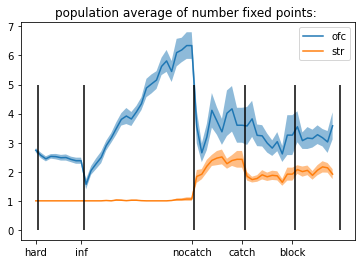

In [36]:
#fig D plotting

warped = True

if warped:
    nuse_ofc = npts_all_warped  
    nuse_str = npts_all_warped_str
    ev_use = Tmedians
    ev_use_str = Tmedians_str
else:
    nuse_ofc = npts_all
    nuse_str = npts_all_str
    ev_use = tphase
    ev_use_str = tphase_str
    


#ofc
npts_filt = np.nanmean(np.array(nuse_ofc),0)
numrnns = np.sum(~np.isnan(nuse_ofc),axis=0)
npts_std = np.nanstd(np.array(nuse_ofc),0)/np.sqrt(numrnns)

#str
npts_filt_str = np.nanmean(np.array(nuse_str),0)
numrnns_str = np.sum(~np.isnan(nuse_str),axis=0)
npts_std_str = np.nanstd(np.array(nuse_str),0)/np.sqrt(numrnns_str)


plt.plot(npts_filt,label='ofc')
plt.fill_between(range(len(npts_filt)),npts_filt-npts_std, npts_filt+npts_std,alpha=0.5 )

plt.plot(npts_filt_str,label='str')
plt.fill_between(range(len(npts_filt_str)),npts_filt_str-npts_std_str, npts_filt_str+npts_std_str,alpha=0.5 )


plt.title('population average of number fixed points: ')
plt.legend()

#change_idx = np.argwhere(np.diff(ev_use)>0)[:,0]

change_idx = ev_use
print(change_idx)
for k in change_idx:
    plt.vlines(k+0.5,0,5,color='k')

xdict = {0:'simple', 1:'hard', 2:'inf.', 3:'nocatch', 4:'catch', 5:'block'}
labels = ['hard','inf','nocatch','catch','block']
plt.xticks(change_idx[:-1], labels=labels)

savename = savedir+'keplot_overtraining_pop'
plt.savefig(savename +'.pdf')

plt.show()

In [294]:
len(npts_filt)

51

In [15]:
# try analyzing the number and type over learning
#st = 'fixed'
st = 'all'
ttype = 'full_cl_time'
epoch = 'wait'
num = 5
reg_idx = 0
dirnames, tphase = getdirname(ttype,epoch,num,reg_idx)
npts_kind_wait = getnpts(dirnames,tphase,st, eps=eps)



141
65


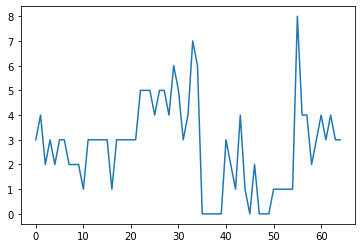

In [16]:

npts_filt = np.array(npts_kind_wait[0])+np.array(npts_kind_wait[1])

npts_filt.shape
good_idx = np.argwhere(~np.isnan(npts_filt))[:,0]
len(good_idx)
npts_filt = npts_filt[good_idx]
len(npts_filt)
print(len(tphase))

tphase_filt = np.array(tphase)[good_idx]

print(len(tphase_filt))

plt.plot(npts_filt,label='all')

In [ ]:
# supp fig. individual networks

# try analyzing the number and type over learning
#st = 'fixed'
st = 'all'
ttype = 'full_cl_time'
epoch = 'wait'
num = 3
reg_idx = 0
eps = 0.1
doadaptive = True
dirnames, tphase = getdirname(ttype,epoch,num,reg_idx)
npts_kind_wait = getnpts(dirnames,tphase,st, eps=eps, doadaptive= doadaptive)

npts_filt = np.array(npts_kind_wait[0])+np.array(npts_kind_wait[1])
good_idx = np.argwhere(~np.isnan(npts_filt))[:,0]
npts_filt = npts_filt[good_idx]
tphase_filt = np.array(tphase)[good_idx]

plt.plot(npts_filt,label='all')

#plt.plot(npts_kind_wait[0],label='fixed')
#plt.plot(npts_kind_wait[1],label='slow')
regd = {0:'OFC', 1:'STR'}

plt.title('number of KE points over training RNN'+str(num)+', '+regd[reg_idx])
plt.legend()
change_idx = np.argwhere(np.diff(tphase_filt)>0)[:,0]
for k in change_idx:
    plt.vlines(k+0.5,0,5,color='k')

xdict = {0:'simple', 1:'hard', 2:'inf.', 3:'nocatch', 4:'catch', 5:'block'}
labels = [xdict[tphase_filt[k+1]] for k in change_idx]
plt.xticks(change_idx, labels=labels)

savename = savedir + 'kemin_overtraining_rnn'+str(num)+'_reg'+str(reg_idx)
plt.savefig(savename+'.pdf')


plt.show()


#by node type

npts_filt = np.array(npts_kind_wait[0])+np.array(npts_kind_wait[1])
good_idx = np.argwhere(~np.isnan(npts_filt))[:,0]
npts_filt = npts_filt[good_idx]
tphase_filt = np.array(tphase)[good_idx]

plt.plot(np.array(npts_kind_wait[3][0])[good_idx],label='attractors')
plt.plot(np.array(npts_kind_wait[3][1])[good_idx],label='saddles')
plt.plot(np.array(np.array(npts_kind_wait[3][2])[good_idx])+0.1,label='lines')
#plt.plot(npts_kind_wait[3][3],label='sources')
plt.title('number of KE points over training RNN'+str(num)+', '+regd[reg_idx]+'. rel_eps='+str(eps))
plt.legend()

change_idx = np.argwhere(np.diff(tphase_filt)>0)[:,0]
for k in change_idx:
    plt.vlines(k+0.5,0,5,color='k')

xdict = {0:'simple', 1:'hard', 2:'inf.', 3:'nocatch', 4:'catch', 5:'block'}
labels = [xdict[tphase_filt[k+1]] for k in change_idx]
plt.xticks(change_idx, labels=labels)


#savename = savedir + 'kemin_overtraining_bytype_rnn'+str(num)+'_reg'+str(reg_idx)
#plt.savefig(savename+'.pdf')

plt.show()

In [201]:
#gather number of saddles, lines, attractors for each network, do stats

n_attractor = []
n_saddles = []
n_lines = []
restrictrange = False
n_tot = []

for num in range(1,51):
    st = 'all'
    ttype = 'full_cl_time'
    epoch = 'wait'
    reg_idx = 0
    eps = 0.01
    doadaptive = True
    restrictrange = False
    
    dirnames, tphase = getdirname(ttype,epoch,num,reg_idx)
    try:
        dirnames = ['/scratch/dh148/dynamics/results/rnn/ac/20231003/full_cl/dynamics/KEmin_constrained/kemin_rnn_curric_'+str(num)+'_block_10reg_0_mixed_wait.dat']
        npts_kind_wait = getnpts(dirnames,tphase,st, eps=eps, doadaptive= doadaptive,restrictrange=restrictrange)
    except:
        continue


    n_attractor.append(npts_kind_wait[3][0][-1])
    n_saddles.append(npts_kind_wait[3][1][-1])
    n_lines.append(npts_kind_wait[3][2][-1])
    n_tot.append(npts_kind_wait[2])
    

/state/partition1/job-40654310/ipykernel_3965862/4003007559.py:42: RuntimeWarning: divide by zero encountered in true_divide
  sdiffnorm = 2 * np.sqrt(KE) * lam / (np.linalg.norm(crds, axis=1))


In [195]:
print(len(n_attractor))


45


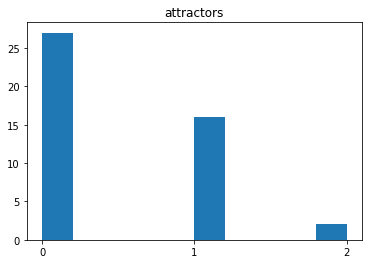

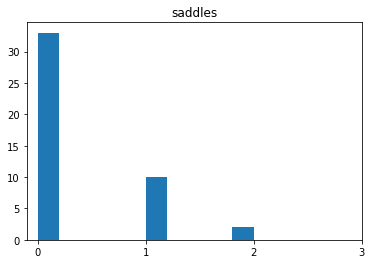

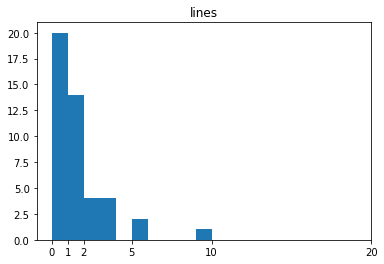

In [197]:
plt.hist(n_attractor,stacked=False)
plt.title('attractors')
plt.xticks([0,1,2])
plt.show()

plt.hist(n_saddles,stacked=False)
plt.title('saddles')
plt.xticks([0,1,2,3])
plt.show()


plt.hist(n_lines,bins=list(range(20)))
plt.title('lines')
plt.xticks([0,1,2,5,10,20])
plt.show()


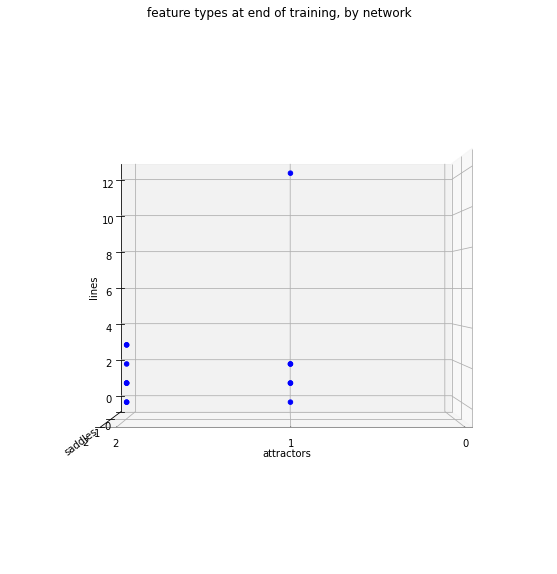

In [202]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

n_atr = np.array(n_attractor)
n_sad = np.array(n_saddles)
n_line = np.array(n_lines)

mask_n0 = n_sad==0
mask_n1 = n_sad==1
mask_n2 = n_sad==2
mask_n3 = n_sad==3

#ax.scatter(n_atr[mask_n0], n_sad[mask_n0], n_line[mask_n0],color='red')
ax.scatter(n_atr[mask_n1], n_sad[mask_n1], n_line[mask_n1],color='blue')
#ax.scatter(n_atr[mask_n2], n_sad[mask_n2], n_line[mask_n2],color='green')
#ax.scatter(n_atr[mask_n3], n_sad[mask_n3], n_line[mask_n3],color='magenta')
ax.set_xlabel('attractors')
ax.set_ylabel('saddles')
ax.set_zlabel('lines')
ax.view_init(elev=00, azim=90)
ax.set_xticks([0,1,2])
ax.set_yticks([0,1,2])
plt.xticks

plt.title('feature types at end of training, by network')

plt.show()

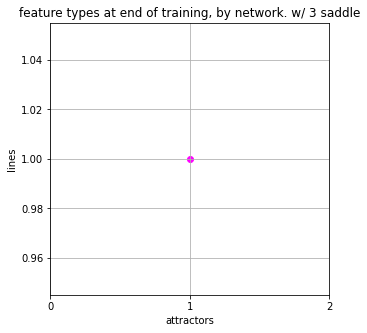

In [214]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()

n_atr = np.array(n_attractor)
n_sad = np.array(n_saddles)
n_line = np.array(n_lines)

mask_n0 = n_sad==0
mask_n1 = n_sad==1
mask_n2 = n_sad==2
mask_n3 = n_sad==3

#ax.scatter(n_atr[mask_n0], n_line[mask_n0],color='red', s=50)
#ax.scatter(n_atr[mask_n1], n_line[mask_n1],color='blue',s=50)
#ax.scatter(n_atr[mask_n2], n_line[mask_n2],color='green',s=50)
ax.scatter(n_atr[mask_n3], n_line[mask_n3],color='magenta')
ax.set_xlabel('attractors')
ax.set_ylabel('lines')
ax.set_xticks([0,1,2])
#ax.set_yticks([0,1,2])
plt.grid()

plt.title('feature types at end of training, by network. w/ 3 saddle')

plt.show()

In [125]:
linelens = []
for j in range(len(npts_kind_wait[7])):
    lines_j = []
    for k in range(len(npts_kind_wait[7][j])):
        if npts_kind_wait[7][j][k] == 'line':
            lines_j.append(npts_kind_wait[6][j][k])
    if len(lines_j) > 0:
        linelens.append(lines_j)
        
        
test = [np.sum(np.array(k)) for k in linelens]


Text(0.5, 1.0, 'total length of all line attractors over training')

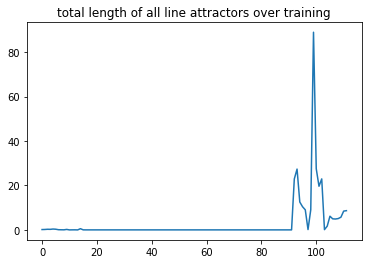

In [126]:
plt.plot(test)
plt.title('total length of all line attractors over training')

In [86]:
# eventual fig.  try to correlate wait time behavior with number or type of features

#the real dir
subdirlist = ['full_cl/', 'nok_cl/','nok_nocl/', 'full_cl_redo/', 'pkind_mem/', 'pkind_pred/']
dbase = '/scratch/dh148/dynamics/results/rnn/ac/20230206_clstudy/'
datadir_dat = lambda s_idx: dbase+subdirlist[s_idx]
configdir = lambda s_idx: '/home/dh148/projects/dynamics/jobs/20230206_clstudy/rnn/'+subdirlist[s_idx]


fgen = lambda num,idx, base, sess, s_idx : datadir_dat(s_idx)+str(num)+'/'+base + str(num)+'_'+sess+'_'+str(idx)

fname_funs = [lambda num,idx, s_idx: datadir_dat(s_idx)+str(num)+'/'+'rnn_kindergarten_' + str(num)+'_simple',
              lambda num,idx, s_idx: datadir_dat(s_idx)+str(num)+'/'+'rnn_kindergarten_' + str(num)+'_int',
              lambda num,idx, s_idx: datadir_dat(s_idx)+str(num)+'/'+'rnn_pred_' + str(num)+'_pred_1',
              lambda num,idx, s_idx: fgen(num, idx, 'rnn_curric_', 'nocatch', s_idx),
              lambda num,idx, s_idx: fgen(num, idx, 'rnn_curric_', 'catch', s_idx),
              lambda num,idx, s_idx: fgen(num, idx, 'rnn_curric_', 'block', s_idx),
              lambda num,idx, s_idx: fgen(num, idx, 'rnn_curric_', 'block', s_idx)+'_freeze'
             ]


#decide here what you want to look at
idx = 10  # plce in CL stage
t_idx = 5  # CL stage
s_idx = 3 #CL type
fname_fun_j = lambda j: fname_funs[t_idx](j,idx, s_idx)+'.stats'


numuse = []
for j in range(1,21):
    fname_stats = fname_fun_j(j)

    if os.path.exists(fname_stats):
        numuse.append(j)
print(numuse)
        
nuse = len(numuse)
ratios = []


for j in numuse:
    num = j
    fname_stats = fname_fun_j(j)
    #print(fname_stats)
    dat_stat = pickle.load(open(fname_stats,'rb'))
    pval,slope,adapt_20_ratio,nums, wtrange,b, wtdat, reg_histdat, reg_blockdat = parse.load_dat4stats(fname_stats)
    ratios.append(adapt_20_ratio)



[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19]


In [111]:
reg_idx = 0
st = 'all'

dirnames, tphase = getdirname('full_cl','wait', reg_idx=reg_idx)
npts_kind_wait = getnpts(dirnames,tphase,st)

nfix = npts_kind_wait[0]
nslow = npts_kind_wait[1]
npt = npts_kind_wait[2]
nattractor = npts_kind_wait[3][0]
nsaddle = npts_kind_wait[3][1]
nline = npts_kind_wait[3][2]
nsource = npts_kind_wait[3][3]

#the rnn number in the KE indexing
kenum = [int(k.split('/')[-1].split('_')[3]) for k in dirnames]

In [123]:
len(nslow)

15

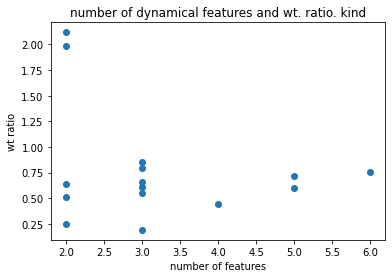

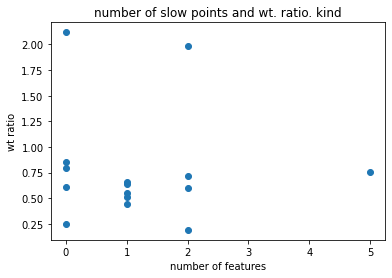

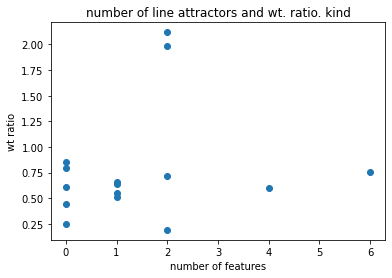

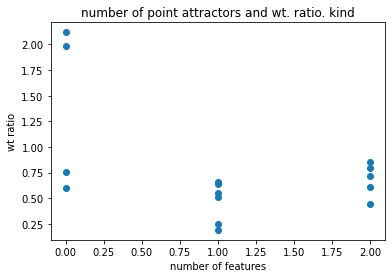

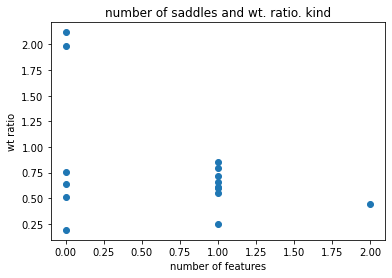

In [129]:
indexing = np.array([numuse.index(k) for k in kenum])
test = np.array(ratios)[indexing]
plt.scatter(npt,test)
plt.title('number of dynamical features and wt. ratio. kind')
plt.xlabel('number of features')
plt.ylabel('wt ratio')
plt.show()

indexing = np.array([numuse.index(k) for k in kenum])
plt.scatter(nslow,test)
plt.title('number of slow points and wt. ratio. kind')
plt.xlabel('number of features')
plt.ylabel('wt ratio')
plt.show()

indexing = np.array([numuse.index(k) for k in kenum])
plt.scatter(nline,test)
plt.title('number of line attractors and wt. ratio. kind')
plt.xlabel('number of features')
plt.ylabel('wt ratio')
plt.show()

indexing = np.array([numuse.index(k) for k in kenum])
plt.scatter(nattractor,test)
plt.title('number of point attractors and wt. ratio. kind')
plt.xlabel('number of features')
plt.ylabel('wt ratio')
plt.show()

indexing = np.array([numuse.index(k) for k in kenum])
plt.scatter(nsaddle,test)
plt.title('number of saddles and wt. ratio. kind')
plt.xlabel('number of features')
plt.ylabel('wt ratio')
plt.show()



In [120]:
print(numuse.index(kenum[1]))
print(ratios[3])
test[1]

3
0.5517150141837674


0.5517150141837674

In [101]:
idx = 1
print(kenum[idx])
print(numuse.index(kenum[idx]))
print(ratios[numuse.index(kenum[idx])])

5
3
0.5517150141837674


In [108]:
[numuse.index(kenum)

ValueError: [18, 5, 19, 4, 2, 7, 3, 13, 8, 16, 11, 14, 10, 6, 9] is not in list